### Glow Normalizing Flow Model

In [25]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.distributions as D
import torchvision
import torchvision.transforms as transforms
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Model Implementation

In [ ]:
class Actnorm(nn.Module):
    # Act Norm Transformation
    def __init__(self, in_channel):
        super(Actnorm, self).__init__()
        
        size = (1, in_channel, 1, 1)
        self.b = nn.Parameter(torch.zeros(size))
        self.s = nn.Parameter(torch.zeros(size))
        self.initialized = False 
    
    def initialize(self, x):
        with torch.no_grad():
            mean = x.clone().mean(dim=0,keepdim=True).mean(dim=2,keepdim=True).mean(dim=3,keepdim=True)
            self.b.data.copy_(-mean)
            std = ((x.clone() - mean)**2).mean(dim=0,keepdim=True).mean(dim=2,keepdim=True).mean(dim=3,keepdim=True)
            self.s.data.copy_(1 / (std + 1e-6))
            
    def forward(self, x):
        _, _, h, w = x.shape
        
        if not self.initialized:
            self.initialize(x)
            self.initialized = True
        
        log_det = h * w * torch.sum(torch.log(torch.abs(self.s)))
        
        return self.s * x + self.b, log_det
    
    def reverse(self,y):
        return (y - self.b) / self.s

In [27]:
class Invertible_Conv(nn.Module):
    # Invertible 1 × 1 convolution Transformation
    def __init__(self, in_channel):
        super(Invertible_Conv, self).__init__()
        
        size = (in_channel, in_channel, 1, 1)
        W_init = torch.randn(in_channel, in_channel)
        Q, R = torch.linalg.qr(W_init)
        self.W = nn.Parameter(Q.reshape(size))
    
    def forward(self, x):
        _, _, h, w = x.shape
        x = F.conv2d(x, self.W)
        log_det = h * w * torch.log(torch.abs(torch.det(self.W.squeeze())))
        return x, log_det
    
    def reverse(self, y):
        return F.conv2d(y, self.W.squeeze().inverse().unsqueeze(2).unsqueeze(3))

In [28]:
class NN(nn.Module):
    # Network utilized in Affine Coupling Transformation
    def __init__(self, in_channel, out_channel):
        super(NN, self).__init__()
        self.c1 = nn.Conv2d(in_channel, 512, kernel_size=3, stride=1, padding=1, bias=True)  
        self.c2 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, bias=True)
        self.c3 = nn.Conv2d(512, out_channel, kernel_size=3, stride=1, padding=1, bias=True)
        
        with torch.no_grad():
            nn.init.normal_(self.c1.weight, mean=0, std=0.05)
            nn.init.zeros_(self.c1.bias)
            nn.init.normal_(self.c2.weight, mean=0, std=0.05)
            nn.init.zeros_(self.c2.bias) 
            nn.init.zeros_(self.c3.weight)
            nn.init.zeros_(self.c3.bias)
        
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = self.c3(x)
        return x
            

In [29]:
class Affine_Coupling(nn.Module):
    # Affine Coupling Transformation
    def __init__(self, in_channel):
        super(Affine_Coupling, self).__init__()
        self.in_channel = in_channel
        self.Net = NN(in_channel=self.in_channel//2, out_channel=self.in_channel)
         
    def split(self, z):
        za = z[:,:self.in_channel//2,:,:] 
        zb = z[:,self.in_channel//2:,:,:]
        return za, zb
    
    def forward(self, x):
        xa, xb = self.split(x) 
        s_t = self.Net(xb)
        log_s, t = self.split(s_t)
        s = torch.exp(log_s)
        ya = s * xa + t
        yb = xb 
        y = torch.cat([ya,xb],1)
        log_det = torch.log(s).view(x.shape[0], -1)
        log_det = torch.sum(log_det, 1)
        return y, log_det
    
    def reverse(self, y):
        ya, yb = self.split(y)
        s_t = self.Net(yb)
        log_s, t = self.split(s_t)
        s = torch.exp(log_s)
        xa = (ya - t) / s
        x = torch.cat([xa, yb],1)
        return x 
    

In [30]:
class Flow_Step(nn.Module):
    # Flow Layer 
    def __init__(self, in_channel):
        super(Flow_Step, self).__init__()
        self.Actnorm = Actnorm(in_channel)
        self.Invertible_Conv = Invertible_Conv(in_channel)
        self.Affine_Coupling = Affine_Coupling(in_channel)
    
    def forward(self, x):
        x, log_det1 = self.Actnorm(x) 
        x, log_det2 = self.Invertible_Conv(x)
        x, log_det3 = self.Affine_Coupling(x) 
        
        return x, log_det1 + log_det2 + log_det3
        
    def reverse(self, y): 
        x = self.Affine_Coupling.reverse(y)
        x = self.Invertible_Conv.reverse(x)
        x = self.Actnorm.reverse(x) 
        return x

In [31]:
class Squeeze(nn.Module):
    # Squeeze Layer 
    def __init__(self, scale):
        super(Squeeze, self).__init__()
        self.scale = scale
    
    def forward(self, x):
        n, n_channel, height, width = x.shape
        return x.view(n, n_channel*(self.scale ** 2), height//self.scale, width//self.scale)
    
    def reverse(self, y): 
        n, n_channel, height, width = y.shape
        return y.view(n, n_channel//(self.scale**2), height*self.scale, width*self.scale)

In [32]:
class Split(nn.Module):
    # Split Layer
    def __init__(self):
        super(Split, self).__init__()
    
    def forward(self, x):
        _,n_channel,_,_ = x.shape
        x1 = x[:,:n_channel//2,:,:]
        x2 = x[:,n_channel//2:,:,:]
        return x1, x2
    
    def reverse(self, x1, x2):
        return torch.cat([x1, x2], 1)

In [33]:
class Glow(nn.Module):
    # Glow multi-layer architecture
    def __init__(self, input_image_shape, K, L):
        super(Glow, self).__init__()
        img_channel, img_width, img_height = input_image_shape
        self.glow_blocks = nn.ModuleList()
        
        for l in range(L-1):
            squeeze_obj = Squeeze(scale=2)
            self.glow_blocks.append(squeeze_obj)
            img_channel = img_channel * 4
            for k in range(K):
                flow_step_obj = Flow_Step(img_channel)                
                self.glow_blocks.append(flow_step_obj)
            split_obj = Split()
            self.glow_blocks.append(split_obj)
            img_channel = img_channel // 2
        squeeze_obj_L = Squeeze(scale=2)
        self.glow_blocks.append(squeeze_obj_L)
        img_channel = img_channel * 4
        flow_step_obj_L =Flow_Step(img_channel)
        self.glow_blocks.append(flow_step_obj_L)
    
    def forward(self, x):
        n, n_channel, height, width = x.shape
        log_det = torch.tensor(0.0,requires_grad=False)
        z_i_data = []
        for i in range(len(self.glow_blocks)):
            layer = self.glow_blocks[i].__class__.__name__
            if layer == "Squeeze":
                x = self.glow_blocks[i](x)
            elif layer == "Flow_Step":
                x, log_det = self.glow_blocks[i](x)
            elif layer == "Split":
                x, z_i = self.glow_blocks[i](x)
                z_i_data.append(z_i)
        z_i_data.append(x)
        
        return z_i_data, log_det
    
    def reverse(self, z):
        z = [z[i] for i in range(len(z))]
        x = z[-1]
        idx = len(z)-2
        for j in range(len(self.glow_blocks)-1,-1,-1):
            layer = self.glow_blocks[j].__class__.__name__
            if layer == "Squeeze":
                x = self.glow_blocks[j].reverse(x) 
            elif layer == "Flow_Step":
                x = self.glow_blocks[j].reverse(x) 
            elif layer == "Split":
                x = self.glow_blocks[j].reverse(x,z[idx])
                idx -= 1
        
        return x 

In [34]:
def log_prob(z, log_det):
    #log-likelihood function utilized to create loss function
    dist_mean = torch.zeros(1)
    dist_var = torch.ones(1)
    base_dist = D.Normal(dist_mean, dist_var)
    output = 0
    for i in range(len(z)):
        log_prob = base_dist.log_prob(z[i]).sum()
        output += log_prob.item()
    return output + log_det

#### Training

In [133]:
glow_model = Glow((1,28,28),20,2)

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
data_size = 2000
data_idx =  torch.randperm(len(train_set))
data_idx = data_idx[:data_size]
sub_dataset = torch.utils.data.Subset(train_set, data_idx)
train_loader = torch.utils.data.DataLoader(sub_dataset, batch_size=1, shuffle=True)

T = transforms.Resize((24,24))
optimizer = torch.optim.Adam(glow_model.parameters(), lr=0.01)

for batch_id, (data, _) in enumerate(train_loader):
    data_reshape = T(data)
    zs, log_det = glow_model(data_reshape)
    loss = -log_prob(zs, log_det.item())
    loss = torch.tensor(loss, requires_grad=True)
    loss = torch.nan_to_num(loss, nan=1e10, posinf=1e10)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#### Testing

In [148]:
def plot_sample():
    test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

    for batch_id, (data, _) in enumerate(test_loader):
        print("Original Image:")
        fig = plt.figure
        plt.imshow(data.reshape(28,28))
        plt.show()

        T = transforms.Resize((24,24))
        data_reshape = T(data)
        zs, _ = glow_model(data_reshape)
        sample_recov = glow_model.reverse(zs)

        inv_T = transforms.Resize((28,28))
        sample_recov_reshape = inv_T(sample_recov)
        
        print("Reconstructed Image utilizing Glow Model:")
        fig = plt.figure
        plt.imshow(sample_recov_reshape.detach().reshape(28,28))
        plt.show()    
        break 
    print("----------------------------------------")

Original Image:


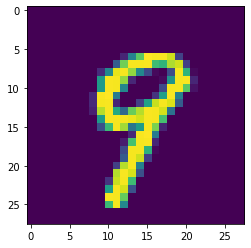

Reconstructed Image utilizing Glow Model:


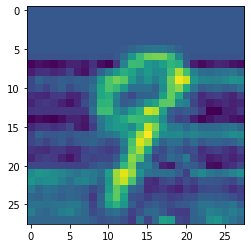

----------------------------------------
Original Image:


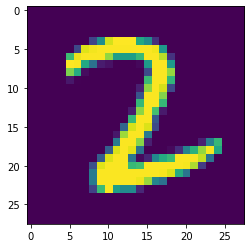

Reconstructed Image utilizing Glow Model:


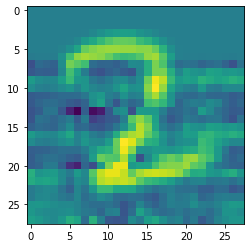

----------------------------------------
Original Image:


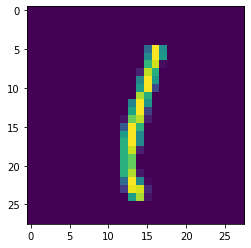

Reconstructed Image utilizing Glow Model:


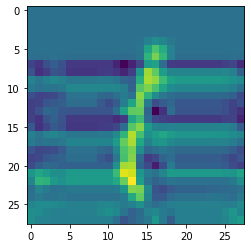

----------------------------------------
Original Image:


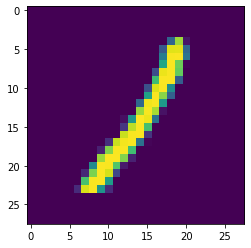

Reconstructed Image utilizing Glow Model:


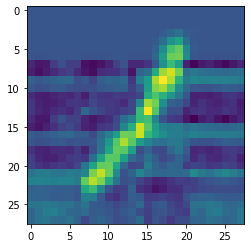

----------------------------------------
Original Image:


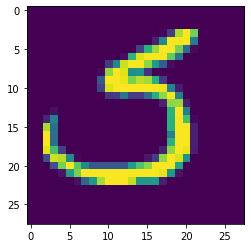

Reconstructed Image utilizing Glow Model:


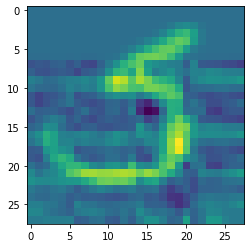

----------------------------------------
Original Image:


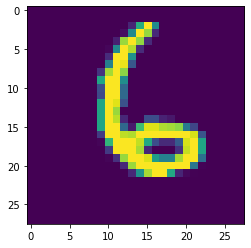

Reconstructed Image utilizing Glow Model:


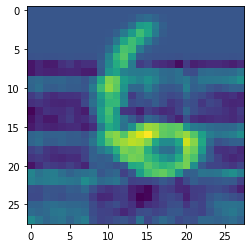

----------------------------------------
Original Image:


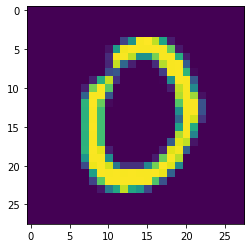

Reconstructed Image utilizing Glow Model:


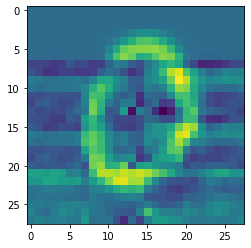

----------------------------------------
Original Image:


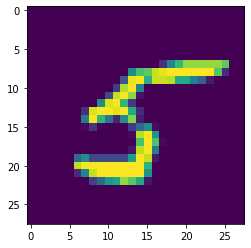

Reconstructed Image utilizing Glow Model:


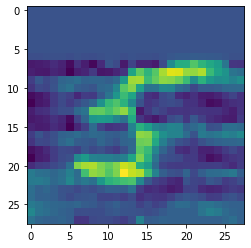

----------------------------------------
Original Image:


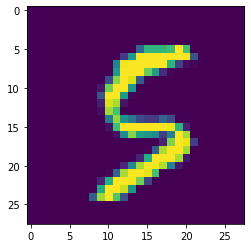

Reconstructed Image utilizing Glow Model:


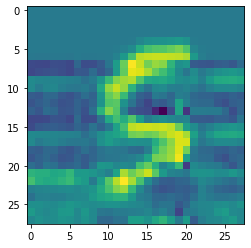

----------------------------------------
Original Image:


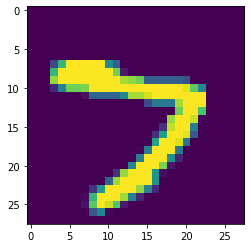

Reconstructed Image utilizing Glow Model:


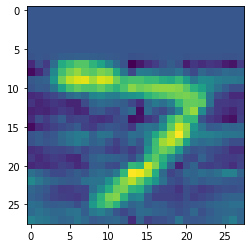

----------------------------------------
Original Image:


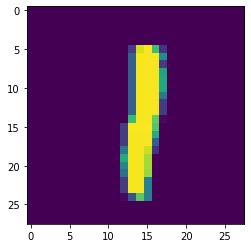

Reconstructed Image utilizing Glow Model:


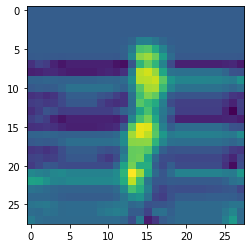

----------------------------------------
Original Image:


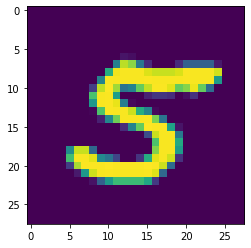

Reconstructed Image utilizing Glow Model:


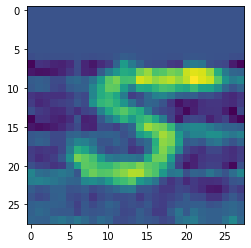

----------------------------------------
Original Image:


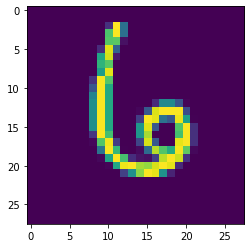

Reconstructed Image utilizing Glow Model:


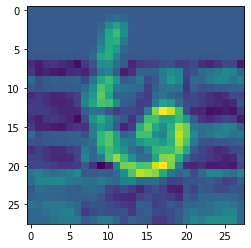

----------------------------------------
Original Image:


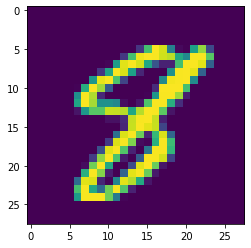

Reconstructed Image utilizing Glow Model:


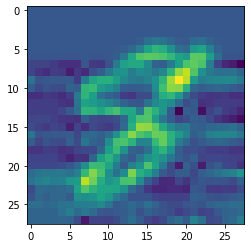

----------------------------------------
Original Image:


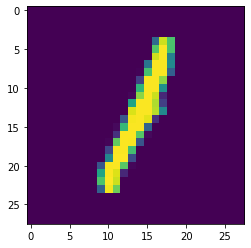

Reconstructed Image utilizing Glow Model:


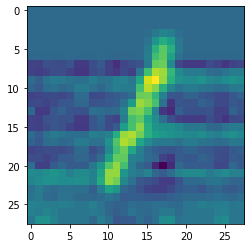

----------------------------------------


In [150]:
for i in range(15):
    plot_sample()